To begin copy this notebook to your own drive:

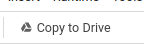


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=e0a07fda-ab98-479a-bee2-d16b3b066981
To: /content/glove.npy
100%|██████████| 480M/480M [00:06<00:00, 73.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 94.1MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch]

In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [5]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [6]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-7-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [9]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
# for A
'''
class DAN(nn.Module):
  def __init__(self, drop_out_rate):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.dropout = nn.Dropout(drop_out_rate)
          # YOUR CODE HERE
          self.classifier = nn.Sequential(
            nn.Linear(self.embeddings.embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_labels)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END


  def forward(self,input_ids,attention_masks, labels=None, **kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      if self.training:
            embeddings = self.dropout(embeddings)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

'''

'\nclass DAN(nn.Module):\n  def __init__(self, drop_out_rate):\n          super().__init__()\n          self.num_labels = 2\n          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))\n          self.dropout = nn.Dropout(drop_out_rate)\n          # YOUR CODE HERE\n          self.classifier = nn.Sequential(\n            nn.Linear(self.embeddings.embedding_dim, 128),\n            nn.ReLU(),\n            nn.Linear(128, 64),\n            nn.ReLU(),\n            nn.Linear(64, 32),\n            nn.ReLU(),\n            nn.Linear(32, self.num_labels)\n          )\n          self.loss = nn.CrossEntropyLoss()\n          # END YOUR END\n        \n\n  def forward(self,input_ids,attention_masks, labels=None, **kwargs):\n      # YOUR CODE HERE\n      embeddings = self.embeddings(input_ids) \n      if self.training:\n            embeddings = self.dropout(embeddings)\n      avg = torch.mean(embeddings, dim=1)\n      # END YOUR END\n      res = self.classifier(avg

In [10]:
from transformers import TrainerCallback

class AccuracyLoggingCallback(TrainerCallback):
    def __init__(self):
        self.epoch_eval_accuracies = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and 'eval_accuracy' in metrics:
            self.epoch_eval_accuracies.append(metrics['eval_accuracy'])


In [11]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
#B
'''
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_callback import DefaultFlowCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10, #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=0.015,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

models = []
trainers = []
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for p in dropout_rates:
  accuracy_callback = AccuracyLoggingCallback()
  m = DAN(drop_out_rate=p)
  models.append(m)
  trainer = Trainer(
    model=m,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                 DefaultFlowCallback(),
                 accuracy_callback
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
  )
  trainers.append((trainer, accuracy_callback))
'''

'\nfrom transformers import Trainer\nfrom transformers import TrainingArguments\nfrom transformers.trainer_callback import DefaultFlowCallback\n\nco = DataCollatorWithPadding()\ntraining_args = TrainingArguments("DAN",\n                                  # YOUR CODE HERE\n                                  num_train_epochs=10, #must be at least 10.\n                                  per_device_train_batch_size=16,\n                                  per_device_eval_batch_size=16,\n                                  learning_rate=0.015,\n                                  # END YOUR END\n                                  \n                                  save_total_limit=2,\n                                  log_level="error",\n                                  evaluation_strategy="epoch")\n\nmodels = []\ntrainers = []\ndropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]\nfor p in dropout_rates:\n  accuracy_callback = AccuracyLoggingCallback()\n  m = DAN(drop_out_rate=p)\n  models.append(m)\n  

In [12]:
# B
# Train each model and collect accuracy data
'''
model_names = ["Model 0 (Dropout 0.)", "Model 1 (Dropout 0.1)", "Model 2 (Dropout 0.2)", "Model 3 (Dropout 0.3)", "Model 4 (Dropout 0.4)", "Model 5 (Dropout 0.5)"]
best_accuracies = []
for trainer, accuracy_callback in trainers:
    trainer.train()
    best_accuracy = max(accuracy_callback.epoch_eval_accuracies)
    best_accuracies.append(best_accuracy)
'''


'\nmodel_names = ["Model 0 (Dropout 0.)", "Model 1 (Dropout 0.1)", "Model 2 (Dropout 0.2)", "Model 3 (Dropout 0.3)", "Model 4 (Dropout 0.4)", "Model 5 (Dropout 0.5)"]\nbest_accuracies = []\nfor trainer, accuracy_callback in trainers:\n    trainer.train()\n    best_accuracy = max(accuracy_callback.epoch_eval_accuracies)\n    best_accuracies.append(best_accuracy)\n'

In [13]:
# for B
# Plotting the accuracies
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(model_names, best_accuracies)

plt.xlabel('model')
plt.ylabel('Best accuracy')
plt.title('Evaluation Accuracy per dropout rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'accuracy_plot.png'
plt.savefig('accuracy_plot_per_dropout_rate.png')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 6))\nplt.plot(model_names, best_accuracies)\n\nplt.xlabel('model')\nplt.ylabel('Best accuracy')\nplt.title('Evaluation Accuracy per dropout rate')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\n\n# Save the plot as 'accuracy_plot.png'\nplt.savefig('accuracy_plot_per_dropout_rate.png')\nplt.show()\n"

In [14]:
# for A
'''import matplotlib.pyplot as plt

epochs = range(1, training_args.num_train_epochs + 1)
print(epochs)
print(accuracy_callback.epoch_eval_accuracies)
plt.plot(epochs, accuracy_callback.epoch_eval_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Evaluation Accuracy')
plt.title('Evaluation Accuracy per Epoch')
plt.grid(True)
plt.show()
plt.savefig('plot.png')'''

"import matplotlib.pyplot as plt\n\nepochs = range(1, training_args.num_train_epochs + 1)\nprint(epochs)\nprint(accuracy_callback.epoch_eval_accuracies)\nplt.plot(epochs, accuracy_callback.epoch_eval_accuracies, marker='o')\nplt.xlabel('Epoch')\nplt.ylabel('Evaluation Accuracy')\nplt.title('Evaluation Accuracy per Epoch')\nplt.grid(True)\nplt.show()\nplt.savefig('plot.png')"

In [15]:
# C
'''
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_callback import DefaultFlowCallback
class DAN_C(nn.Module):
    def __init__(self, num_hidden_layers):
        super().__init__()
        self.num_labels = 2
          # YOUR CODE HERE
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = 128
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        layers = []
        if self.num_hidden_layers == 0:
            layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
        else:
            for i in range(num_hidden_layers):
                if i == 0:
                    layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_size))
                else:
                    layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                layers.append(nn.ReLU(),)
            layers.append(nn.Linear(self.hidden_size, self.num_labels),)
        self.classifier = nn.Sequential(*layers)
        self.loss = nn.CrossEntropyLoss()
        # END YOUR END

    def forward(self,input_ids,attention_masks, labels=None, **kwargs):
        # YOUR CODE HERE
        embeddings = self.embeddings(input_ids)
        avg = torch.mean(embeddings, dim=1)
        # END YOUR END
        res = self.classifier(avg)
        loss = self.loss(res,labels)
        return {"loss":loss,"logits":res}
'''

'\nfrom transformers import Trainer\nfrom transformers import TrainingArguments\nfrom transformers.trainer_callback import DefaultFlowCallback\nclass DAN_C(nn.Module):\n    def __init__(self, num_hidden_layers):\n        super().__init__()\n        self.num_labels = 2\n          # YOUR CODE HERE\n        self.num_hidden_layers = num_hidden_layers\n        self.hidden_size = 128\n        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))\n        layers = []\n        if self.num_hidden_layers == 0:\n            layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]\n        else:\n            for i in range(num_hidden_layers):\n                if i == 0:\n                    layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_size))\n                else:\n                    layers.append(nn.Linear(self.hidden_size, self.hidden_size))\n                layers.append(nn.ReLU(),)\n            layers.append(nn.Linear(self.hi

In [16]:
# C
'''
class AccuracyLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.epoch_eval_accuracies = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and 'eval_accuracy' in metrics:
            self.epoch_eval_accuracies.append(metrics['eval_accuracy'])

# Initialize the data collator
co = DataCollatorWithPadding()

# Define training arguments
training_args = TrainingArguments(
    "DAN",
    num_train_epochs=10,  # must be at least 10.
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=0.015,
    save_total_limit=2,
    log_level="error",
    evaluation_strategy="epoch"
)

# Define number of layers
num_layers = [0, 1, 2, 3]
models = []
trainers = []

# Create models and trainers for each number of layers
for n in num_layers:
    model = DAN_C(num_hidden_layers=n)
    models.append(model)

    # Create a new AccuracyLoggingCallback instance for each model
    accuracy_callback = AccuracyLoggingCallback()

    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks=[
            DefaultFlowCallback(),
            accuracy_callback
        ],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainers.append((trainer, accuracy_callback))

# Train each model and collect accuracy data
best_accuracies = []
for trainer, accuracy_callback in trainers:
    trainer.train()
    best_accuracy = max(accuracy_callback.epoch_eval_accuracies)
    best_accuracies.append(best_accuracy)

# Plotting the best accuracies
plt.figure(figsize=(8, 6))
plt.plot(num_layers, best_accuracies, marker='o', linestyle='-', color='b', label='Best Accuracy')

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Best Accuracy')
plt.title('Best Evaluation Accuracy for Different Number of Hidden Layers')
plt.xticks(num_layers)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot as 'best_accuracy_layers.png'
plt.savefig('best_accuracy_layers.png')
plt.show()
'''

'\nclass AccuracyLoggingCallback(TrainerCallback):\n    def __init__(self):\n        super().__init__()\n        self.epoch_eval_accuracies = []\n\n    def on_evaluate(self, args, state, control, metrics=None, **kwargs):\n        if metrics is not None and \'eval_accuracy\' in metrics:\n            self.epoch_eval_accuracies.append(metrics[\'eval_accuracy\'])\n\n# Initialize the data collator\nco = DataCollatorWithPadding()\n\n# Define training arguments\ntraining_args = TrainingArguments(\n    "DAN",\n    num_train_epochs=10,  # must be at least 10.\n    per_device_train_batch_size=16,\n    per_device_eval_batch_size=16,\n    learning_rate=0.015,\n    save_total_limit=2,\n    log_level="error",\n    evaluation_strategy="epoch"\n)\n\n# Define number of layers\nnum_layers = [0, 1, 2, 3]\nmodels = []\ntrainers = []\n\n# Create models and trainers for each number of layers\nfor n in num_layers:\n    model = DAN_C(num_hidden_layers=n)\n    models.append(model)\n    \n    # Create a new Acc

In [22]:
# D
import torch
from torch import nn
import numpy as np
from transformers import TrainerCallback, Trainer, TrainingArguments, DefaultFlowCallback, DataCollatorWithPadding
from transformers import Trainer
from transformers import TrainingArguments

class DAN_D(nn.Module):
    def __init__(self, num_hidden_layers, activation_function):
        super().__init__()
        self.num_labels = 2
        # YOUR CODE HERE
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = 128
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        layers = []
        if self.num_hidden_layers == 0:
            layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
        else:
            for i in range(num_hidden_layers):
                if i == 0:
                    layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_size))
                else:
                    layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                layers.append(activation_function)
            layers.append(nn.Linear(self.hidden_size, self.num_labels),)
        self.classifier = nn.Sequential(*layers)
        self.loss = nn.CrossEntropyLoss()
        # END YOUR END
    def forward(self,input_ids, labels=None, **kwargs):
        # YOUR CODE HERE
        embeddings = self.embeddings(input_ids)
        avg = torch.mean(embeddings, dim=1)
        # END YOUR END
        res = self.classifier(avg)
        loss = self.loss(res,labels)
        return {"loss":loss,"logits":res}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5759, 'grad_norm': 2.850815534591675, 'learning_rate': 0.014600127959053102, 'epoch': 0.3198976327575176}
{'loss': 0.4646, 'grad_norm': 1.7837860584259033, 'learning_rate': 0.014200255918106206, 'epoch': 0.6397952655150352}
{'loss': 0.4328, 'grad_norm': 0.870256245136261, 'learning_rate': 0.013800383877159308, 'epoch': 0.9596928982725528}
{'eval_loss': 0.44542622566223145, 'eval_accuracy': 0.78932, 'eval_runtime': 28.7136, 'eval_samples_per_second': 870.667, 'eval_steps_per_second': 54.434, 'epoch': 1.0}
{'loss': 0.4134, 'grad_norm': 0.36991286277770996, 'learning_rate': 0.01340051183621241, 'epoch': 1.2795905310300704}
{'loss': 0.4206, 'grad_norm': 0.499484121799469, 'learning_rate': 0.013000639795265514, 'epoch': 1.599488163787588}
{'loss': 0.4193, 'grad_norm': 1.2380361557006836, 'learning_rate': 0.012600767754318617, 'epoch': 1.9193857965451055}
{'eval_loss': 0.39388981461524963, 'eval_accuracy': 0.82468, 'eval_runtime': 27.053, 'eval_samples_per_second': 924.112, 'eval_

ConversionError: Failed to convert value(s) to axis units: ['ReLU', 'Tanh', 'Sigmoid']

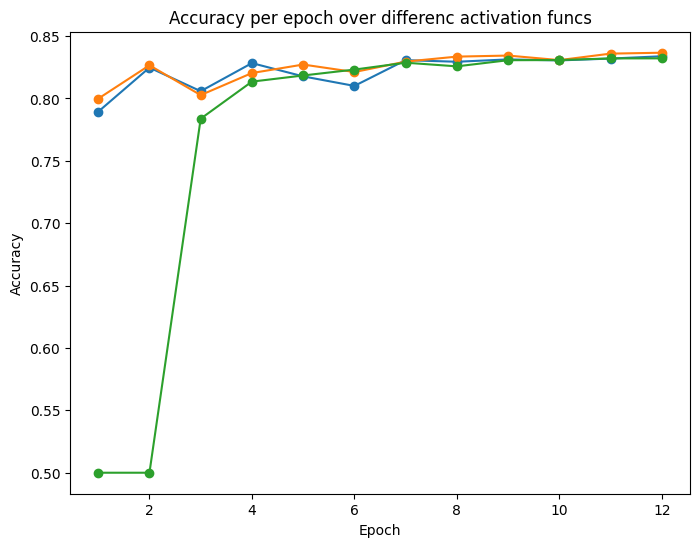

In [25]:
# D
from transformers import TrainerCallback, Trainer, TrainingArguments, DefaultFlowCallback, DataCollatorWithPadding
from transformers import AutoTokenizer
class AccuracyLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.epoch_eval_accuracies = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and 'eval_accuracy' in metrics:
            self.epoch_eval_accuracies.append(metrics['eval_accuracy'])

# Initialize the tokenizer- added because without this got error
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") # Replace with the appropriate tokenizer

# Initialize the data collator, passing the tokenizer as an argument
co = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    "DAN",
    num_train_epochs=12,  # must be at least 10.
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=0.015,
    save_total_limit=2,
    log_level="error",
    evaluation_strategy="epoch"
)

# Define activation functions
activation_functions = [nn.ReLU(), nn.Mish(), nn.Sigmoid()]
activation_names = ["ReLU", "Tanh", "Sigmoid"]
num_hidden_layers = 2
models = []
trainers = []

# Create models and trainers for each activation function
for activation_function in activation_functions:
    model = DAN_D(num_hidden_layers=num_hidden_layers, activation_function=activation_function)
    models.append(model)

    # Create a new AccuracyLoggingCallback instance for each model
    accuracy_callback = AccuracyLoggingCallback()

    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks=[
            DefaultFlowCallback(),
            accuracy_callback
        ],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainers.append((trainer, accuracy_callback))

# Train each model and collect accuracy data
accuracies = []
for trainer, accuracy_callback in trainers:
    trainer.train()
    accuracies.append(accuracy_callback.epoch_eval_accuracies)


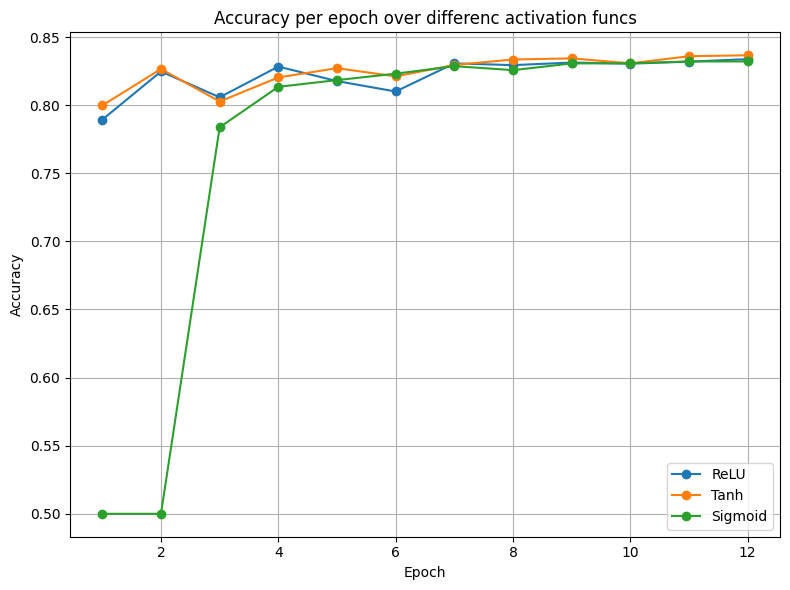

In [26]:

# Plotting the best accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
epochs = [1,2,3,4,5,6,7,8,9,10,11,12]

for i in range(len(accuracies)):
  acc = accuracies[i]
  plt.plot(epochs, acc, marker='o', linestyle='-', label=activation_names[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch over differenc activation funcs')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot as 'best_accuracy_activations.png'
plt.savefig('best_accuracy_activations.png')
plt.show()


In [34]:
import random
import numpy as np

# Assuming models[1] and its corresponding trainer are already defined and trained
model = models[1]
trainer = trainers[1][0]  # trainers[1] contains (trainer, accuracy_callback), so we take the trainer

# Get predictions on the evaluation set
predictions = trainer.predict(small_eval_dataset)

# Get logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids

# Convert logits to predicted labels
predicted_labels = np.argmax(logits, axis=1)

# Identify incorrect predictions
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Sample 5 incorrect predictions
sampled_indices = random.sample(list(incorrect_indices.astype(int)), 5)

# Retrieve the corresponding samples, move i to int because it its np.int which is not int
incorrect_samples = [(small_eval_dataset[int(i)], predicted_labels[int(i)], true_labels[int(i)]) for i in sampled_indices]

for i in range(len(incorrect_samples)):
  print(incorrect_samples[i][0]['text'])
  print("predicted: ",True if incorrect_samples[i][1] == 1 else False)
  print("true labels: ", True if incorrect_samples[i][2] ==1 else False)


One should have the right to expect from people who make a film about the Second Coming and the Third Testament, that they had read the other two, or at least knew a little more about them than miracles and Judgement Day. This film contains absolutely nothing of relevance for viewers who are interested in Jesus, religion or philosophy -- there is only the standard British social realism with guttural dialects and plump characters in pubs.<br /><br />Actually, good candidates for a real Third Testament have been published several times - like "A Course in Miracles" or "Conversations with God". They all have thought-provoking new twists and angles for Christian faith and theology.<br /><br />The most interesting information in IMDb's rating is not the number of stars, but how many people who have bothered to vote. In four years, only 387 people have bothered to vote for this film. As usual, the enthusiasts are the most eager. For comparison, have a look at "Jesus Christ, Superstar" - ori